In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
en_stopwords = stopwords.words('english')

pd.set_option('display.max_colwidth', None)

In [3]:
import sys
import os
sys.path.append('../src-py/')
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from ca_utils import *

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

2022-08-08 16:10:06,766 loading file ../../data-ceph/arguana/arg-generation/claim-target-tagger/model/final-model.pt
2022-08-08 16:10:33,694 SequenceTagger predicts: Dictionary with 4 tags: <unk>, B-CT, I-CT, O


In [3]:
torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

device(type='cuda')

In [4]:
from transformers import BertForSequenceClassification, AutoTokenizer, TextClassificationPipeline

#take top quality counter from the dataset!
gretz_model = BertForSequenceClassification.from_pretrained('../../../data-ceph/arguana/arg-generation/argument-quality/argument-quality-model/checkpoint-9000', local_files_only=True, cache_dir='cache')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', cache_dir='cache')

arg_quality_pipeline = TextClassificationPipeline(model=gretz_model, tokenizer=tokenizer, framework='pt', task='ArgQ', device=0)

def get_best_argumentative_comment(comments):    
    comments = [' '.join(x) for x in comments]
    # set the pipeline
    results = arg_quality_pipeline(comments, truncation=True)
    comments_scores = []
    for result_dict in results:
        comments_scores.append(result_dict['score'])
    
    comments = sorted(list(zip(comments, comments_scores)), key= lambda x: -x[1])
    return comments[0][0]

### Preparing the data:
- Starting from jo_data, remove all cases where the comment qoutes the post --> considered undermining
- Second remove bot comments
- Third, split into training, testing, and validation
- For the training process further to only select the comments with good argumentative quality
- ..

In [3]:
rebuttal_df = pd.read_pickle("../../../data-ceph/arguana/arg-generation/argument-undermining/jo_data/argument_rebuttals.pkl")

In [4]:
#First save all the data without masking..
train_df = rebuttal_df[rebuttal_df['split'] == 'train']
dev_df   = rebuttal_df[rebuttal_df['split'] == 'val']
test_df  = rebuttal_df[rebuttal_df['split'] == 'test']

In [8]:
train_df.post_id.nunique()

25704

In [9]:
dev_df.post_id.nunique()

8721

#### Removing the undermining-cases:

The code for this in the arg-undermining project

#### Removing bot comments:

In [ ]:
#1.Remove all cases where there is a bot comment
df['bot_comment'] = df.comment.apply(lambda x:  'i am a bot, and this action was performed automatically.' in ' '.join(x))
df = df.drop(df[df.bot_comment].index)

#### Split the corpus:

In [31]:
#First save all the data without masking..
train_df = rebuttal_df[rebuttal_df['split'] == 'train']
dev_df   = rebuttal_df[rebuttal_df['split'] == 'val']
test_df  = rebuttal_df[rebuttal_df['split'] == 'test']

In [ ]:
dev_df.to_pickle('../../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/reddit_data/conclusion_and_ca_generation/valid_conclusion_all.pkl')
test_df.to_pickle('../../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/reddit_data/conclusion_and_ca_generation/test_conclusion_all.pkl')

#Also save a sample for rapid test
dev_df.drop_duplicates('post_id').sample(2000).to_pickle('../../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/reddit_data/conclusion_and_ca_generation/sample_valid_conclusion_all.pkl')
test_df.drop_duplicates('post_id').sample(2000).to_pickle('../../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/reddit_data/conclusion_and_ca_generation/sample_test_conclusion_all.pkl')

#### Prepare the training data:

In [4]:
train_df = pd.read_pickle('../../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/reddit_data/conclusion_and_ca_generation/preprocessed_train_conclusion_all.pkl')

In [5]:
train_df.head()

,post_id,split,comment_id,title,post,n_sentences,counter,bot_comment,counter_conclusion,counter_conclusions
0,t3_1u4mmo,train,t1_ceehlbn,I believe that churches and other religious institutions should have to pay taxes.,"[i believe that a church is like any other profit making business and therefore most pay similar taxes., i am not a religious person myself so i do not know the complete logistics of the revenue and spending of a church but i do understand they can yield a good amount of cash., not entirely sure how accurate this article is, but it states that we could gain an additional 71 billion dollars per year and in a time where we as a country are in trillions of dollars of debt taxing a church seems reasonable to me., cmv]",4,1. it can be used as a chilling effect that can be enforced in discriminating ways. 2. just because the nation is in debt does not justify collecting additional taxes. they've already proven themselves irresponsible with the trillions they do collect. collecting more won't cause them to become responsible. 3. other non profit organizations are tax exempt. 4. taxing someone subjects them to governmental oversight which creates an intermingling of church and state. when money exchanges between government and an institution the two infiltrate and influence one another.,False,"Tax exemptions are a privilege and should not automatically be granted to any organisation, including churches.",Taxes are theft because the money is used for purposes that the taxed may find abhorrent; it thus violates people's freedom to spend their money.
22,t3_1u4mo5,train,t1_ceegi4s,I don't believe it is acceptable to attack the person that your SO cheated on you with.,"[so it seems to be common that, when caught cheating, violence is directed toward the person the significant other so cheated with., i don't understand why., you were in a relationship with your so., you had no agreement with the other party., if you are going to beat the shit out of anyone, it should be your so., s he is the one that cheated on you., the other party, provided they aren't a friend or acquaintance doesn't owe you anything., why should beating the ever loving shit out of your so's cheat mate be acceptable?]",8,"you presumably love your so and hope to fix your relationship, so attacking them would be counterproductive. as for the violence itself, i think the level of emotional damage caused by being cheated on is significantly worse than getting punched a few times i don't see why people have such a prejudice against physical violence compared to other, more subtle and painful forms of injury such as emotional.",False,I believe that physical violence is never more harmful than other forms of violence.,I believe that physical violence against a partner is more harmful than any other form of violence.
38,t3_1u4txm,train,t1_ceeioxh,"There is no viable alternative to capitalism, though the current system can be altered to serve people's needs.","[i've tried researching discussions on this topic before but i only found ones involving incredibly biased participants., hope you guys can do better i honestly don't understand how there is a significant number of people who believe that capitalism can be replaced., history shows that absolutely no ruler in a socialist or communist regime is capable of upholding their ideals., if you subscribe to the notion that socialism communism is supposed to exist without a state, then i respond that in any circumstance, whether it's survival or business, etc, people will gravitate towards leaders, whether it's in a formal or informal fashion for instance, my workplace has a fairly 'flat' structure but even within my group, i always seek the advice of the more experienced people ., furthermore, even though i do agree that everyone has the right to have their most basic needs fulfilled via, say, some basic income that allows people to eat, drink water and practice basic hygiene with anything else having to be worked fo

##### Select high quality comments to be the counters

In [ ]:
post_to_comments_df = train_df.groupby('post_id').agg({'counter': lambda x: list(x)}).reset_index()
post_to_comments_df['best_comment'] = post_to_comments_df.counter.apply(lambda x: get_best_argumentative_comment(x))
post_to_best_comment = pd.Series(post_to_comments_df.best_comment.values,index=post_to_comments_df.post_id).to_dict()

In [ ]:
train_df['counter'] = train_df.post_id.apply(lambda x: post_to_best_comment[x]) #override the comments with the best one...

In [ ]:
train_df.drop_duplicates('post_id').to_pickle('../../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/reddit_data/conclusion_and_ca_generation/preprocessed_train_conclusion_all.pkl')

##### Generate conclusions for the comments:

In [36]:
train_df = pd.read_pickle('../../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/reddit_data/conclusion_and_ca_generation/preprocessed_train_conclusion_all.pkl')
#Load the preprocessed one because we already generated the targets and stances from the claim-target-extration notebook
valid_df = pd.read_pickle('../../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/reddit_data/conclusion_and_ca_generation/sample_valid_conclusion_all_preprocessed.pkl') 
#Load the preprocessed one because we already generated the targets and stances from the claim-target-extration notebook
test_df  = pd.read_pickle('../../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/reddit_data/conclusion_and_ca_generation/sample_test_conclusion_all_preprocessed.pkl')

In [37]:
num_seq = 5

gen_kwargs = {
    "do_sample": True, 
    "max_length":200,
    "top_p":0.90, 
    "num_return_sequences":num_seq
}

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
        
def get_best_conclusion(stance_scores):
    res = list(zip(stance_scores[0], stance_scores[1][1], stance_scores[1][2]))
    filtered_res = [x for x in res if x[1]==1] #keep only the ones that looks like countering the argument's conclusion
    if len(filtered_res) > 0:
        return sorted(filtered_res, key=lambda x: -x[2])[0][0] #pick the one that the model is sure of the most
    else:
        return sorted(res, key=lambda x: -x[2])[0][0] #pick the one that the model is sure of the most

def generate_counter_conclusions(arg_conclusions, counters):
    #generate the conclusions
    conclusions = generate_conclusion(counters, gen_kwargs, batch_size=8)
    #remove dublicate conclusions so we don't have to process them
    conclusions = [list(set(c)) for c in chunks(conclusions, num_seq)] 
    arg_conclusion_and_counter_conclusions = list(zip(arg_conclusions, conclusions))
    
    #compute stances of generated conclusions towards the original argument's conclusion
    stance_scores = []
    for c in arg_conclusion_and_counter_conclusions:
        stance_scores.append((c[1], get_stance_scores([c[0]] * len(c[1]), c[1])))
    
    #get best conclusion of the candidates
    final_conclusions = [ get_best_conclusion(conc_set) for conc_set in stance_scores]
    return final_conclusions

In [42]:
counter_conclusions = generate_counter_conclusions(train_df['title'].tolist(),  train_df['counter'].tolist())
train_df['counter_conclusion'] = counter_conclusions

  0%|          | 0/26 [00:00<?, ?ba/s]

/usr/local/lib/python3.6/dist-packages/transformers/pipelines/base.py:998: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


In [43]:
train_df.to_pickle('../../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/reddit_data/conclusion_and_ca_generation/preprocessed_train_conclusion_all.pkl') 

In [44]:
counter_conclusions = generate_counter_conclusions(valid_df['title'].tolist(),  valid_df['counter'].tolist())
valid_df['counter_conclusion'] = counter_conclusions
valid_df.to_pickle('../../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/reddit_data/conclusion_and_ca_generation/sample_valid_conclusion_all_preprocessed.pkl') 

  0%|          | 0/2 [00:00<?, ?ba/s]

/usr/local/lib/python3.6/dist-packages/transformers/pipelines/base.py:998: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


In [45]:
counter_conclusions = generate_counter_conclusions(test_df['title'].tolist(), test_df['counter'].tolist())
test_df['counter_conclusion'] = counter_conclusions
test_df.to_pickle('../../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/reddit_data/conclusion_and_ca_generation/sample_test_conclusion_all_preprocessed.pkl') 

  0%|          | 0/2 [00:00<?, ?ba/s]

### Data Analysis:

In [5]:
df = pd.read_pickle('../../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/reddit_data/conclusion_and_ca_generation/preprocessed_train_conclusion_all.pkl')

In [19]:
df['arg_len'] = df['post'].apply(lambda x: len(' '.join(x).split()))
df['counter_conclusion_len'] = df['counter_conclusion'].apply(lambda x: len(' '.join(x).split()))
df['counter_len'] = df['counter'].apply(lambda x: len(' '.join(x).split()))

DescribeResult(nobs=25704, minmax=(18, 7720), mean=609.5545051353874, variance=256135.31547439232, skewness=3.1203514361245084, kurtosis=19.270959098792662)


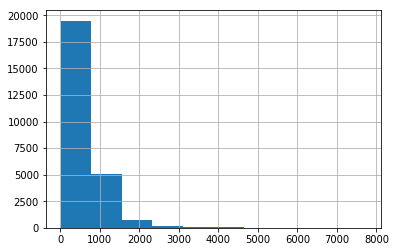

In [21]:
df.counter_len.hist()
print(stats.describe(df.counter_len))

DescribeResult(nobs=25704, minmax=(14, 259), mean=56.36258948023654, variance=408.28084916329595, skewness=1.2817425734335934, kurtosis=3.110149983781798)


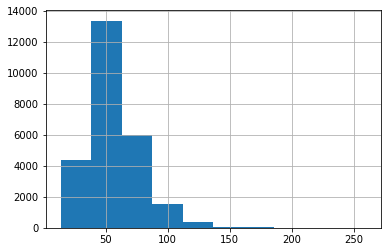

In [22]:
df.counter_conclusion_len.hist()
print(stats.describe(df.counter_conclusion_len))

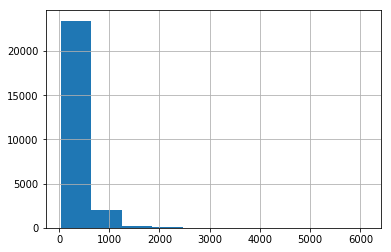

In [10]:
df.arg_len.hist()

In [12]:
import scipy.stats as stats

In [14]:
stats.describe(df.arg_len)

DescribeResult(nobs=25704, minmax=(37, 6098), mean=325.7589091192032, variance=69359.20705597836, skewness=4.015820669815308, kurtosis=40.21213988492746)